##### Student Name: Dinh Nghi Dung Le
##### Student ID: 46150641

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import math
import copy
import pingouin as pg
from statsmodels.stats.weightstats import ttest_ind
import scipy.stats as stats
from gpxutils import parse_gpx 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
%matplotlib inline

# Analysis of Cycling Data

We are provided with four files containing recordings of cycling activities that include GPS location data as
well as some measurements related to cycling performace like heart rate and power.  The goal is to perform
some exploration and analysis of this data. 

The data represents four races.  Two are time trials where the rider rides alone on a set course.  Two are 
road races where the rider rides with a peleton.  All were held on the same course but the road races include
two laps where the time trials include just one. 

Questions to explore with the data:
* What is the overall distance travelled for each of the rides? What are the average speeds etc.  Provide a summary for each ride.
* Compare the range of speeds for each ride, are time trials faster than road races? 
* Compare the speeds achieved in the two time trials (three years apart).  As well as looking at the averages, can you see where in the ride one or the other is faster.  
* From the elevation_gain field you can see whether the rider is _climbing_ , _descending_ or on the _flat_.   Use this to calculate the average speeds in those three cases (climbing, flat or descending).  Note that _flat_ might not be zero elevation_gain but might allow for slight climbs and falls.  

For time varying data like this it is often useful to _smooth_ the data using eg. a [rolling mean](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.rolling_mean.html).  You might want to experiment with smoothing in some of your analysis (not required but may be of interest).

## Description of Fields

* _index_ is a datetime showing the time that the observation was made (I wasn't riding at night, this is converted to UTC)
* __latitude, longitude, elevation__ from the GPS, the position of the rider at each timepoint, elevation in m
* __temperature__ the current ambient temperature in degrees celcius
* __power__ the power being generated by the rider in Watts
* __cadence__ the rotational speed of the pedals in revolutions per minute
* __hr__ heart rate in beats per minute
* __elevation_gain__ the change in elevation in m between two observations
* __distance__ distance travelled between observations in km
* __speed__ speed measured in km/h

You are provided with code in [gpxutils.py](gpxutils.py) to read the GPX XML format files that are exported by cycling computers and applications.  The sample files were exported from [Strava](https://strava.com/) and represent four races by Steve Cassidy.


In [2]:
# read the four data files
rr_2016 = parse_gpx('files/Calga_RR_2016.gpx')
tt_2016 = parse_gpx('files/Calga_TT_2016.gpx')
rr_2019 = parse_gpx('files/Calga_RR_2019.gpx')
tt_2019 = parse_gpx('files/Calga_TT_2019.gpx')

In [3]:
# Drop missing values
rr_2016=rr_2016.dropna()
rr_2019=rr_2019.dropna()
tt_2016=tt_2016.dropna()
tt_2019=tt_2019.dropna()

Text(0.5, 1.0, 'Time trials 2019')

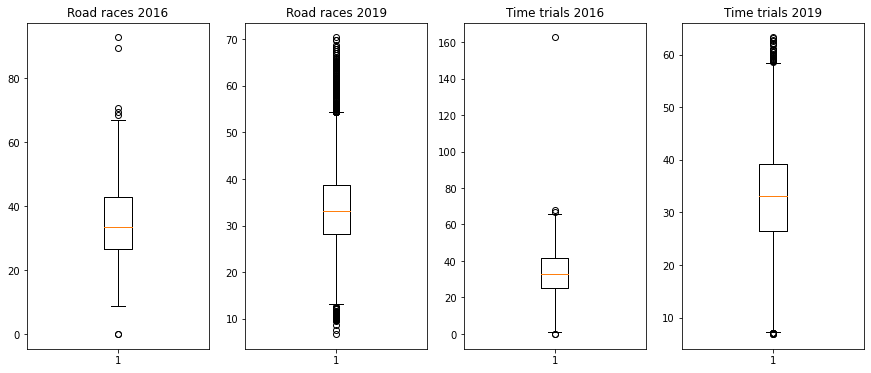

In [4]:
#Original data boxplots
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (15,6))
axes[0].boxplot('speed',data=rr_2016)
axes[0].set_title('Road races 2016')
axes[1].boxplot('speed',data=rr_2019)
axes[1].set_title('Road races 2019')
axes[2].boxplot('speed',data=tt_2016)
axes[2].set_title('Time trials 2016')
axes[3].boxplot('speed',data=tt_2019)
axes[3].set_title('Time trials 2019')

Because all 4 datasets contain outliers and the Road races 2019 dataset has most outliers, removing outliers is neccessary. 

In [5]:
# Detect outliers function
def outliers (df, var):
    Q1=df[var].quantile(0.25)
    Q3=df[var].quantile(0.75)
    IQR=Q3-Q1
    lower_bound=Q1-(1.5*IQR)
    upper_bound=Q3+(1.5*IQR)
    outlier=df.index[(df[var]<lower_bound) | (df[var]>upper_bound)]
    return outlier
# List store outliers 
outlier_list=[]
def outlier_detect (df, var):
    for i in df[var]:
        outlier_list.extend(outliers(df, var))
# Remove outliers
def rev(df, outlier):
    outlier=sorted(set(outlier))
    df=df.drop(outlier)
    return df
#Clean data for rr_2016 
outlier_detect(rr_2016,'speed')
rr_2016=rev(rr_2016,outlier_list)
#Clean data for rr_2019
outlier_list=[]
outlier_detect(rr_2019,'speed')
rr_2019=rev(rr_2019,outlier_list)
#Clean data for tt_2016 
outlier_list=[]
outlier_detect(tt_2016,'speed')
tt_2016=rev(tt_2016,outlier_list)
#Clean data for tt_2019 
outlier_list=[]
outlier_detect(tt_2019,'speed')
tt_2019=rev(tt_2019,outlier_list)

Text(0.5, 1.0, 'Time trials 2019')

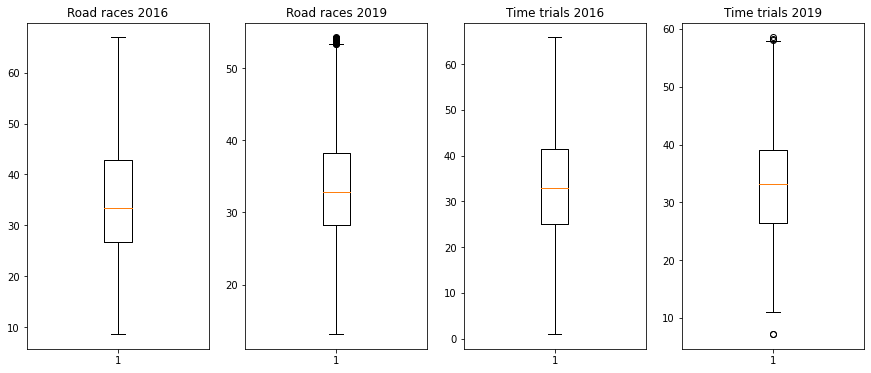

In [6]:
# Cleaned data boxplots 
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (15,6))
axes[0].boxplot('speed',data=rr_2016)
axes[0].set_title('Road races 2016')
axes[1].boxplot('speed',data=rr_2019)
axes[1].set_title('Road races 2019')
axes[2].boxplot('speed',data=tt_2016)
axes[2].set_title('Time trials 2016')
axes[3].boxplot('speed',data=tt_2019)
axes[3].set_title('Time trials 2019')

The data is clean and ready for analysis.

### Question 1

In [7]:
# Question 1
#Road races 2016
rr_2016['overall_distance']=rr_2016['distance'].cumsum() #Overall distance
rr_2016['speed'].mean() #Average speed
rr_2016.describe() #Summary 

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,overall_distance
count,2814.000000,2814.000000,2814.000000,2814.000000,2814.0,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000
mean,-33.367967,151.225535,232.448259,25.277541,0.0,66.036958,158.393746,0.017392,-0.001990,34.893529,1.845060,24.370220
std,0.028330,0.006014,29.738125,1.347041,0.0,34.390959,11.247052,0.015705,0.456757,10.527249,1.694017,14.058488
min,-33.416753,151.211496,176.000000,24.000000,0.0,0.000000,102.000000,0.003271,-1.600000,8.623409,1.000000,0.003271
25%,-33.393659,151.221912,209.600000,24.000000,0.0,68.000000,151.000000,0.007895,-0.400000,26.660689,1.000000,11.996928
50%,-33.371595,151.227240,226.200000,25.000000,0.0,79.000000,158.000000,0.011793,0.000000,33.301330,1.000000,24.415035
75%,-33.342208,151.230073,258.200000,26.000000,0.0,87.000000,166.000000,0.016870,0.400000,42.861094,2.000000,36.495271
max,-33.316890,151.235131,295.800000,30.000000,0.0,117.000000,205.000000,0.076283,1.200000,66.932466,9.000000,48.940037


In [8]:
#Time trials 2016
tt_2016['overall_distance']=tt_2016['distance'].cumsum() #Overall distance
tt_2016['speed'].mean() #Average speed
tt_2016.describe() #Summary 

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,overall_distance
count,1535.000000,1535.000000,1535.000000,1535.000000,1535.0,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000
mean,-33.368068,151.225411,139.092508,10.952443,0.0,83.415635,170.946580,0.016103,-0.000651,33.467068,1.770684,11.760703
std,0.027997,0.006170,30.262974,0.655698,0.0,20.976656,23.227878,0.015895,0.513824,10.894173,1.742797,6.869371
min,-33.418368,151.211206,85.000000,10.000000,0.0,0.000000,101.000000,0.001595,-7.400000,0.991282,1.000000,0.006161
25%,-33.393780,151.221862,116.400000,11.000000,0.0,77.000000,157.000000,0.007630,-0.400000,25.077717,1.000000,5.431650
50%,-33.370463,151.227335,134.000000,11.000000,0.0,86.000000,161.000000,0.010974,0.000000,32.840076,1.000000,11.486853
75%,-33.343373,151.230070,165.400000,11.000000,0.0,96.000000,180.000000,0.015932,0.400000,41.428555,2.000000,17.770187
max,-33.316888,151.235137,202.600000,13.000000,0.0,118.000000,251.000000,0.288175,2.400000,65.840624,31.000000,24.718660


In [9]:
#Road races 2019
rr_2019['overall_distance']=rr_2019['distance'].cumsum() #Overall distance
rr_2019['speed'].mean() #Average speed
rr_2019.describe() #Summary 

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,overall_distance
count,5316.000000,5316.000000,5316.000000,5316.000000,5316.000000,5316.00000,5316.000000,5316.000000,5316.000000,5316.000000,5316.0,5316.000000
mean,-33.371170,151.225283,244.170805,5.999248,217.368134,71.42231,139.149172,0.009278,0.023100,33.400447,1.0,24.263635
std,0.030806,0.006206,29.915233,0.801222,142.582766,28.52588,16.138760,0.002101,0.305449,7.565346,0.0,14.273124
min,-33.422167,151.211507,185.200000,0.000000,0.000000,0.00000,71.000000,0.003650,-1.400000,13.138501,1.0,0.004679
25%,-33.397518,151.221631,220.600000,5.000000,112.000000,69.00000,129.000000,0.007839,-0.200000,28.220026,1.0,11.627270
50%,-33.372737,151.227132,236.800000,6.000000,215.000000,81.00000,143.000000,0.009125,0.000000,32.851363,1.0,24.485098
75%,-33.344122,151.230010,270.400000,7.000000,310.000000,89.00000,152.000000,0.010633,0.200000,38.277136,1.0,36.337053
max,-33.316877,151.235094,310.200000,7.000000,785.000000,120.00000,170.000000,0.015075,1.000000,54.268473,1.0,49.321326


In [10]:
#Time trials 2019
tt_2019['overall_distance']=tt_2019['distance'].cumsum() #Overall distance
tt_2019['speed'].mean() #Average speed
tt_2019.describe() #Summary 

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,overall_distance
count,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2618.0,2618.000000
mean,-33.367993,151.225436,250.975019,10.184492,260.396104,91.063407,153.074102,0.009132,0.011765,32.876763,1.0,11.595641
std,0.028649,0.006268,29.272452,0.815378,75.165379,14.638341,7.254994,0.002580,0.277742,9.288957,0.0,6.854437
min,-33.415735,151.211507,195.800000,9.000000,0.000000,0.000000,89.000000,0.002007,-1.400000,7.223997,1.0,0.002007
25%,-33.394902,151.221305,230.000000,10.000000,215.000000,88.000000,150.000000,0.007346,-0.200000,26.446594,1.0,5.675803
50%,-33.369267,151.227452,244.000000,10.000000,265.500000,94.000000,154.000000,0.009216,0.000000,33.179278,1.0,11.066131
75%,-33.343322,151.230049,276.400000,10.000000,308.000000,98.000000,158.000000,0.010853,0.200000,39.071767,1.0,17.682315
max,-33.316882,151.235098,312.200000,13.000000,500.000000,111.000000,166.000000,0.016255,0.600000,58.517860,1.0,23.908712


<AxesSubplot:>

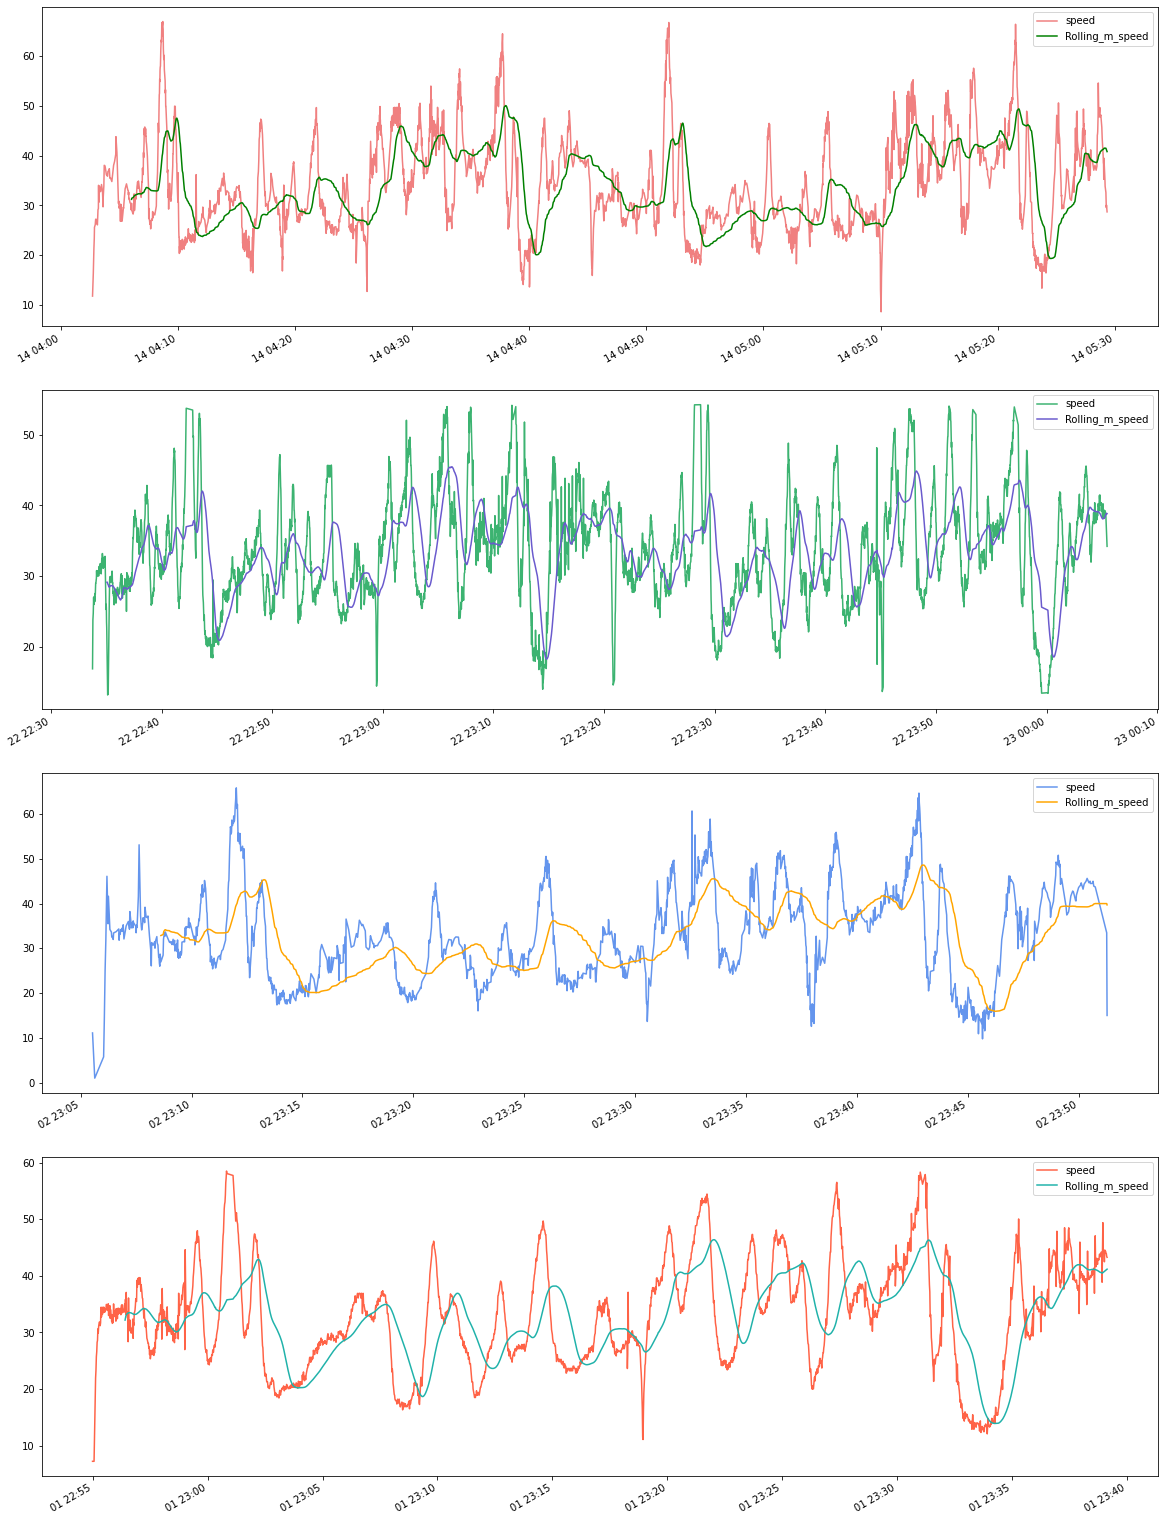

In [26]:
#Smooth data
#Calculate rolling mean for speed
rr_2016['Rolling_m_speed'] = rr_2016['speed'].rolling(window = 80).mean()
rr_2019['Rolling_m_speed'] = rr_2019['speed'].rolling(window = 80).mean()
tt_2016['Rolling_m_speed'] = tt_2016['speed'].rolling(window = 80).mean()
tt_2019['Rolling_m_speed'] = tt_2019['speed'].rolling(window = 80).mean()
#Comparative plots between original speed and rolling mean speed
fig, axes = plt.subplots(nrows = 4, ncols = 1, figsize = (20,30));
rr_2016[['speed', 'Rolling_m_speed']].plot(ax=axes[0], color=['lightcoral', 'green'])
rr_2019[['speed', 'Rolling_m_speed']].plot(ax=axes[1], color=['mediumseagreen', 'slateblue'])
tt_2016[['speed', 'Rolling_m_speed']].plot(ax=axes[2], color=['cornflowerblue', 'orange'])
tt_2019[['speed', 'Rolling_m_speed']].plot(ax=axes[3], color=['tomato', 'lightseagreen'])

## Summary
The overall distance of road races 2016, time trials 2016, road races 2019 and time trials 2019 are respectively 48.94, 24.72, 49.32 and 23.91. The average speed of road races 2016, time trials 2016, road races 2019 and time trials 2019 are respectively 34.89, 33.47, 33.40 and 32.88.

### Question 2 

In [12]:
# Question 2 
# Compare speed range between Road races and Time trials in 2016
range_rr2016 = rr_2016['speed'].max()-rr_2016['speed'].min() #Speed range rr
range_tt2016 = tt_2016['speed'].max()-tt_2016['speed'].min() #Speed range tt
if range_rr2016 > range_tt2016:
    print('Road races 2016 have higher speed range than Time trials 2016')
elif range_rr2016 == range_tt2016:
    print('Speed range is equal')
else:
    print('Road races 2016 have lower speed range than Time trials 2016')
# Compare speed range between Road races and Time trials in 2019
range_rr2019 = rr_2019['speed'].max()-rr_2019['speed'].min() #Speed range rr
range_tt2019 = tt_2019['speed'].max()-tt_2019['speed'].min() #Speed range tt
if range_rr2019 > range_tt2019:
    print('Road races 2019 have higher speed range than Time trials 2019')
elif range_rr2019 == range_tt2019:
    print('Speed range is equal')
else:
    print('Road races 2019 have lower speed range than Time trials 2019')

Road races 2016 have lower speed range than Time trials 2016
Road races 2019 have lower speed range than Time trials 2019


      Race variable      value
0  rr_2016    speed  11.777020
1  rr_2016    speed  16.375033
2  rr_2016    speed  21.243901
3  rr_2016    speed  23.401217
4  rr_2016    speed  25.599979


<AxesSubplot:xlabel='Race', ylabel='value'>

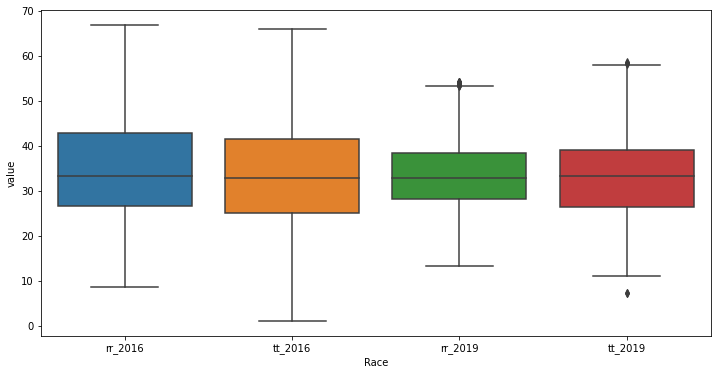

In [13]:
# Compare speed range of 4 datasets
data1 = pd.DataFrame(rr_2016['speed']).assign(Race='rr_2016')
data2 = pd.DataFrame(rr_2019['speed']).assign(Race='rr_2019')
data3 = pd.DataFrame(tt_2016['speed']).assign(Race='tt_2016')
data4 = pd.DataFrame(tt_2019['speed']).assign(Race='tt_2019')
#Concatenate 'speed' columns of 4 datasets
cSpeedRange = pd.concat([data1, data3, data2, data4])    
mSpeedRange = pd.melt(cSpeedRange, id_vars=['Race'])
print(mSpeedRange.head())
plt.figure(figsize=(12,6))
#Plotting boxplot to compare speed range
sns.boxplot(x="Race", y="value", data=mSpeedRange)    

## Conclusion
The boxplot shows that the speed range of road races and time trials in 2016 are quite similar and road races 2016 has slightly lower range than time trials 2016. In 2019, the speed range of road races are much lower than time trials. 

### Question 3

In [28]:
# Question 3
print(tt_2016['speed'].describe())
print(tt_2019['speed'].describe())
# Concatenate 2 datasets
tt_speed=np.concatenate((tt_2016['speed'], tt_2019['speed']))
# Average time trial speed
print(tt_speed.mean())
if tt_2016['speed'].mean() > tt_2019['speed'].mean():
    print('Time trials average speed in 2016 is faster than Time trials average speed in 2019')
elif tt_2016['speed'].mean() == tt_2016['speed'].mean():
    print('Speed in Time trials 2016 and 2019 is equal')
else:
    print('Time trials average speed in 2016 is slower than Time trials average speed in 2019')

count    1535.000000
mean       33.467068
std        10.894173
min         0.991282
25%        25.077717
50%        32.840076
75%        41.428555
max        65.840624
Name: speed, dtype: float64
count    2618.000000
mean       32.876763
std         9.288957
min         7.223997
25%        26.446594
50%        33.179278
75%        39.071767
max        58.517860
Name: speed, dtype: float64
33.094946929771524
Time trials average speed in 2016 is faster than Time trials average speed in 2019


### Hypothesis test
* H0: $\mu_{tt2016}$ = $\mu_{tt2019}$
* H1: $\mu_{tt2016}$ $\neq$ $\mu_{tt2019}$

In [15]:
# Two samples t-test for Time trials 2016 and Time trials 2019, two-tailed test
t_test = stats.ttest_ind(tt_2016['speed'], tt_2019['speed'], 
                      equal_var=False)

display(t_test)

Ttest_indResult(statistic=1.7776081077724402, pvalue=0.0755759801347916)

### Test result
The test shows that there is 7% that the two groups Time trial 2016 and 2019 are identical. For the 95% confidence level, it is fail to reject the null hypothesis. 

### Hypothesis test
* H0: $\mu_{tt2016}$ = $\mu_{tt2019}$
* H1: $\mu_{tt2016}$ $>$ $\mu_{tt2019}$

In [16]:
# Two samples t-test for tt_2016 and tt_2019, one-tailed test (H(A): tt_2016['speed'].mean() > tt_2019['speed'].mean())
t_test_2 = pg.ttest(tt_2016['speed'], tt_2019['speed'], alternative='greater')
display(t_test_2)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.777608,2820.156247,greater,0.037788,"[0.04, inf]",0.059552,0.349,0.582119


### Time trial 2016 and 2019 speed comparison
The one-tailed two samples t-test shows that there is 3% that the two groups Time trial 2016 and 2019 are identical. For the 95% confidence level, we reject the null hypothesis. Time trial 2016 average speed may higher than Time trial 2019 average speed.

### Question 4

In [17]:
# Question 4
rr_2016['elevation_gain'].describe()
climb_speed = []
flat_speed = []
desc_speed = []
def Avg_speed (data):
    if data['elevation_gain'].mean() > 0:
        for i in range (0, data['elevation_gain'].count()):
            if data['elevation_gain'][i] > data['elevation_gain'].mean(): #If elevation gain larger than the average elevation gain, it will become elevation gain for climb speed
                climb_speed.append(data['speed'][i])
            elif data['elevation_gain'][i] < data['elevation_gain'].mean() and data['elevation_gain'][i] > -data['elevation_gain'].mean(): #If elevation gain smaller than the positive average elevation gain and larger than negative average elevation gain, it will become elevation gain for flat speed
                flat_speed.append(data['speed'][i])
            else: #Others will become descending speed
                desc_speed.append(data['speed'][i])
    if data['elevation_gain'].mean() < 0:
        for i in range (0, data['elevation_gain'].count()):
            if data['elevation_gain'][i] > -data['elevation_gain'].mean():
                climb_speed.append(data['speed'][i])
            elif data['elevation_gain'][i] > data['elevation_gain'].mean() and data['elevation_gain'][i] < -data['elevation_gain'].mean():
                flat_speed.append(data['speed'][i])
            elif data['elevation_gain'][i] < data['elevation_gain'].mean():
                desc_speed.append(data['speed'][i])
# Road races 2016
Avg_speed(rr_2016)
print('Climbing speed RR 2016 is', sum(climb_speed)/len(climb_speed)) # Average climbing speed of Road races 2016
print('Flat speed RR 2016 is',sum(flat_speed)/len(flat_speed)) # Average climbing speed of Road races 2016
print('Descending speed RR 2016 is',sum(desc_speed)/len(desc_speed)) # Average climbing speed of Road races 2016
# Time trials 2016
climb_speed = []
flat_speed = []
desc_speed = []
Avg_speed(tt_2016)
print('Climbing speed TT 2016 is', sum(climb_speed)/len(climb_speed)) # Average climbing speed of Time trials 2016
print('Flat speed TT 2016 is', sum(flat_speed)/len(flat_speed)) # Average climbing speed of Time trials 2016
print('Descending speed TT 2016 is', sum(desc_speed)/len(desc_speed)) # Average climbing speed of Time trials 2016
# Road races 2019
climb_speed = []
flat_speed = []
desc_speed = []
Avg_speed(rr_2019)
print('Climbing speed RR 2019 is', sum(climb_speed)/len(climb_speed)) # Average climbing speed of Road races 2019
print('Flat speed RR 2019 is',sum(flat_speed)/len(flat_speed)) # Average climbing speed of Road races 2019
print('Descending speed RR 2019 is',sum(desc_speed)/len(desc_speed)) # Average climbing speed of Road races 2019
# Time trials 2019
climb_speed = []
flat_speed = []
desc_speed = []
Avg_speed(tt_2019)
print('Climbing speed TT 2019 is', sum(climb_speed)/len(climb_speed)) # Average climbing speed of Time trials 2019
print('Flat speed TT 2019 is', sum(flat_speed)/len(flat_speed)) # Average climbing speed of Time trials 2019
print('Descending speed TT 2019 is', sum(desc_speed)/len(desc_speed)) # Average climbing speed of Time trials 2019

Climbing speed RR 2016 is 26.33334092200109
Flat speed RR 2016 is 34.47095040895667
Descending speed RR 2016 is 45.855895419285524
Climbing speed TT 2016 is 24.582851769382092
Flat speed TT 2016 is 34.19217122033553
Descending speed TT 2016 is 44.78262935296798
Climbing speed RR 2019 is 29.077885067252463
Flat speed RR 2019 is 33.39090205554811
Descending speed RR 2019 is 39.73341332443934
Climbing speed TT 2019 is 26.042651343729904
Flat speed TT 2019 is 33.59136002519804
Descending speed TT 2019 is 42.08407392923098


### Summary
* The average climbing speed, flat speed and descending speed for Road Races 2016 are respectively 26.33, 34.47 and 45.86. 
* The average climbing speed, flat speed and descending speed for Time trials 2016 are respectively 24.58, 34.19 and 44.78. 
* The average climbing speed, flat speed and descending speed for Road Races 2019 are respectively 29.08, 33.39 and 39.73. 
* The average climbing speed, flat speed and descending speed for Time trials 2019 are respectively 26.04, 33.59 and 42.08.

## Challenge: Gear Usage

A modern race bike has up to 22 different gears with two chainrings on the front (attached to the pedals) and 10 or 11 at the back (attached to the wheel).   The ratio of the number of teeth on the front and rear cogs determines the distance travelled with one revolution of the pedals (often called __development__, measured in metres).  Low development is good for climbing hills while high development is for going fast downhill or in the final sprint. 

We have a measure of the number of rotations of the pedals per minute (__cadence__) and a measure of __speed__.  Using these two variables we should be able to derive a measure of __development__ which would effectivly tell us which gear the rider was using at the time.   Development will normally range between __2m__ and __10m__.  Due to errors in GPS and cadence measurements you will see many points outside this range and you should just discard them as outliers. 

Write code to calculate __development__ in _meters_ for each row in a ride.  Plot the result in a _histogram_ and compare the plots for the four rides.   Comment on what you observe in the histograms.





### Development in meters formulas
Speed in mph = Speed in km/h $\times$ 0.621 = Gear inches $\times$ Cadence in rpm $\times \frac{\pi}{1056}$  
**Development in meters** = Gear inches $\times$ $0.0254\pi$ = (Speed in km/h $\times 0.621 \times 0.0254 \times 1056$)/ Cadence in rpm = (Speed in km/h $\times 16.6567$)/ Cadence in rpm

In [19]:
pd.options.mode.chained_assignment = None
#Calculate development in meter 
#Road races 2016
rr_2016_df = rr_2016[rr_2016['cadence'] != 0]
rr_2016_df['development']=(rr_2016_df['speed']*16.6567)/(rr_2016_df['cadence'])
rr_2016_df.describe()
#Road races 2019
rr_2019_df = rr_2019[rr_2019['cadence'] != 0]
rr_2019_df['development']=(rr_2019_df['speed']*16.6567)/(rr_2019_df['cadence'])
rr_2019_df.describe()
#Time trials 2016
tt_2016_df = tt_2016[tt_2016['cadence'] != 0]
tt_2016_df['development']=(tt_2016_df['speed']*16.6567)/(tt_2016_df['cadence'])
tt_2016_df.describe()
#Time trials 2019
tt_2019_df = tt_2019[tt_2019['cadence'] != 0]
tt_2019_df['development']=(tt_2019_df['speed']*16.6567)/(tt_2019_df['cadence'])
tt_2019_df.describe()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,overall_distance,Rolling_m_speed,development
count,2589.000000,2589.000000,2589.000000,2589.000000,2589.000000,2589.000000,2589.000000,2589.000000,2589.000000,2589.000000,2589.0,2589.000000,2512.000000,2589.000000
mean,-33.367889,151.225440,251.168482,10.181151,263.312862,92.083430,153.178447,0.009100,0.019003,32.758913,1.0,11.641973,32.728116,6.604925
std,0.028636,0.006283,29.109715,0.812870,70.319465,11.077847,7.033909,0.002521,0.265788,9.076340,0.0,6.846843,6.936618,13.123443
min,-33.415648,151.211507,195.800000,9.000000,0.000000,2.000000,97.000000,0.003354,-1.000000,12.074134,1.0,0.010112,13.914497,2.682200
25%,-33.394955,151.221301,230.200000,10.000000,217.000000,89.000000,151.000000,0.007346,-0.200000,26.444209,1.0,5.779929,28.727716,4.799899
50%,-33.368955,151.227493,244.200000,10.000000,267.000000,94.000000,154.000000,0.009202,0.000000,33.128376,1.0,11.108586,33.186104,5.761413
75%,-33.343162,151.230049,276.600000,10.000000,309.000000,98.000000,158.000000,0.010797,0.200000,38.867828,1.0,17.723941,38.058679,6.685019
max,-33.316934,151.235095,312.000000,13.000000,500.000000,111.000000,166.000000,0.016083,0.600000,57.899053,1.0,23.908712,46.388485,393.877362


In [20]:
#Remove outliers for development column
#Road races 2016
index_rr2016 = rr_2016_df[(rr_2016_df['development'] < 2) | (rr_2016_df['development'] > 10)].index
rr_2016_df.drop(index_rr2016, inplace = True)
#Road races 2019
index_rr2019 = rr_2019_df[(rr_2019_df['development'] < 2) | (rr_2019_df['development'] > 10)].index
rr_2019_df.drop(index_rr2019, inplace = True)
rr_2019_df.describe()
#Time trials 2016
index_tt2016 = tt_2016_df[(tt_2016_df['development'] < 2) | (tt_2016_df['development'] > 10)].index
tt_2016_df.drop(index_tt2016, inplace = True)
tt_2016_df.describe()
#Time trials 2019
index_tt2019 = tt_2019_df[(tt_2019_df['development'] < 2) | (tt_2019_df['development'] > 10)].index
tt_2019_df.drop(index_tt2019, inplace = True)
tt_2019_df.describe()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,overall_distance,Rolling_m_speed,development
count,2547.000000,2547.000000,2547.000000,2547.000000,2547.000000,2547.000000,2547.000000,2547.000000,2547.000000,2547.000000,2547.0,2547.000000,2470.000000,2547.000000
mean,-33.367886,151.225421,251.276090,10.188064,266.806439,93.037691,153.255202,0.009048,0.028269,32.574471,1.0,11.618730,32.678306,5.771345
std,0.028741,0.006315,29.077906,0.813022,65.134828,7.758086,7.008807,0.002483,0.254021,8.940337,0.0,6.854006,6.929562,1.311760
min,-33.415648,151.211507,195.800000,9.000000,54.000000,38.000000,97.000000,0.003354,-1.000000,12.074134,1.0,0.010112,13.914497,2.682200
25%,-33.394966,151.221222,230.400000,10.000000,220.000000,89.000000,151.000000,0.007339,-0.200000,26.422030,1.0,5.774864,28.659912,4.789683
50%,-33.368955,151.227501,244.200000,10.000000,268.000000,94.000000,154.000000,0.009168,0.000000,33.004085,1.0,11.033151,33.162989,5.747461
75%,-33.342988,151.230058,276.600000,10.000000,310.000000,98.000000,158.000000,0.010716,0.200000,38.575864,1.0,17.719017,37.955592,6.577830
max,-33.316985,151.235095,312.000000,13.000000,500.000000,111.000000,166.000000,0.016083,0.600000,57.899053,1.0,23.908712,46.388485,9.872969


In [30]:
#Road races 2016
rr_2016_df['development'].describe()

count    2187.000000
mean        6.233384
std         1.159121
min         2.870511
25%         5.387807
50%         6.201569
75%         6.998932
max         9.970706
Name: development, dtype: float64

In [31]:
#Road races 2019
rr_2019_df['development'].describe()

count    4249.000000
mean        6.336528
std         1.224301
min         3.429292
25%         5.457196
50%         6.423725
75%         6.989484
max         9.995574
Name: development, dtype: float64

In [32]:
#Time trials 2016
tt_2016_df['development'].describe()

count    1452.000000
mean        6.101545
std         1.321354
min         2.624341
25%         5.068495
50%         6.044739
75%         7.118533
max         9.701978
Name: development, dtype: float64

In [33]:
#Time trials 2019
tt_2019_df['development'].describe()

count    2547.000000
mean        5.771345
std         1.311760
min         2.682200
25%         4.789683
50%         5.747461
75%         6.577830
max         9.872969
Name: development, dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

Text(0.5, 1.0, 'Time trials 2019 development')

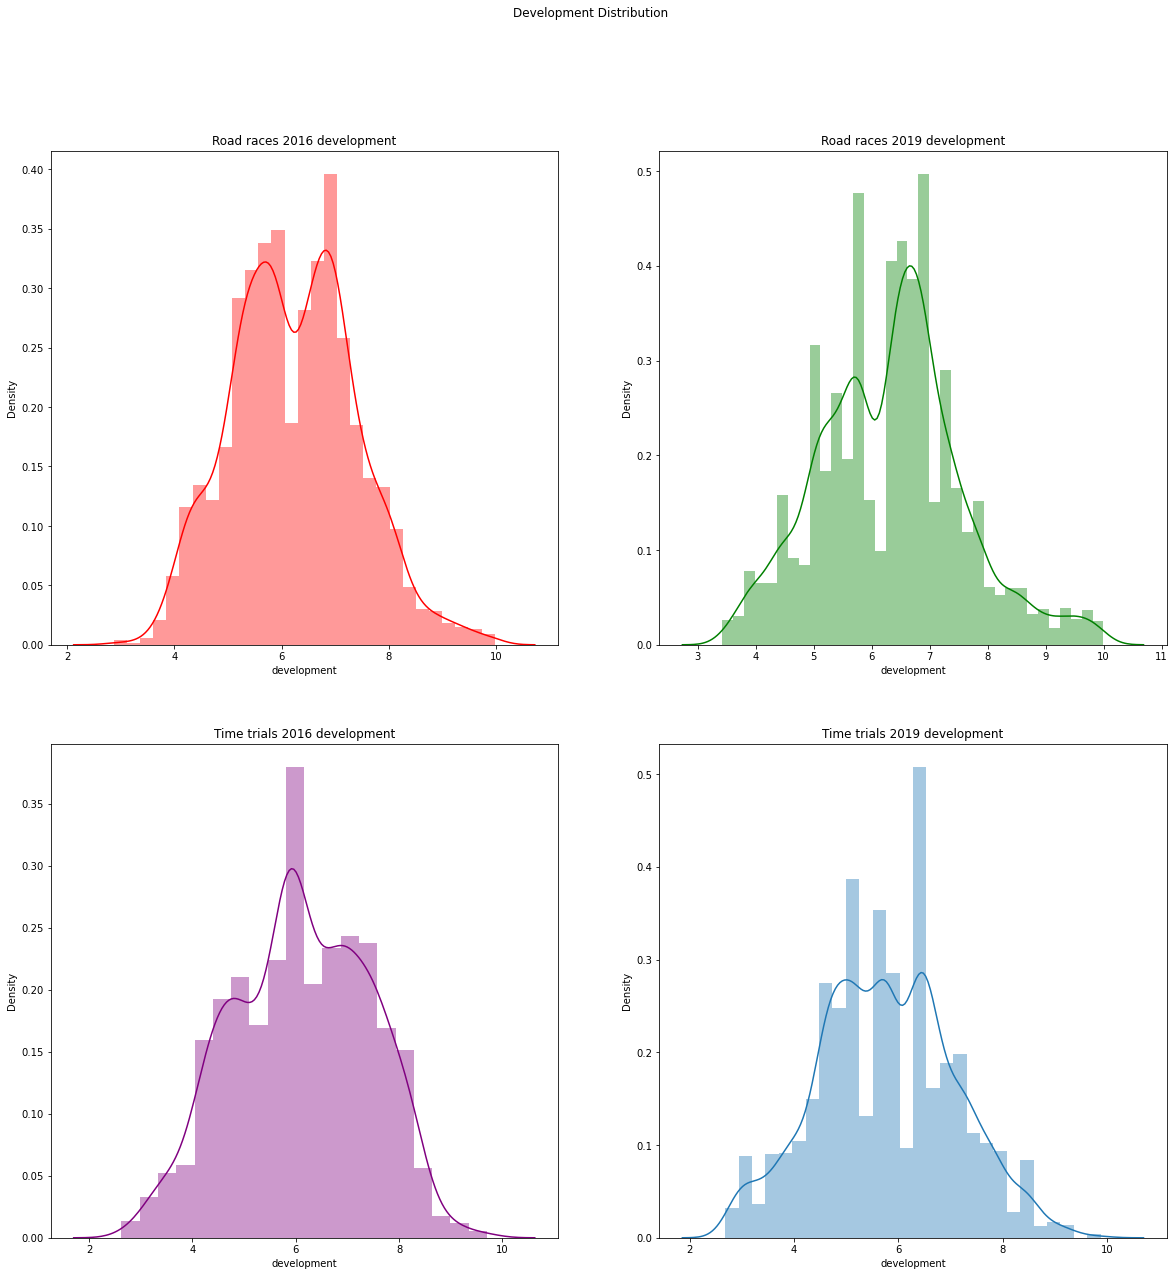

In [46]:
# Development distribution plot 
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
fig.suptitle('Development Distribution')
sns.distplot(rr_2016_df.development, color="red", ax=axes[0, 0])
axes[0, 0].set_title('Road races 2016 development')
sns.distplot(rr_2019_df.development, color="green", ax=axes[0, 1])
axes[0, 1].set_title('Road races 2019 development')
sns.distplot(tt_2016_df.development, color="purple", ax=axes[1, 0])
axes[1, 0].set_title('Time trials 2016 development')
sns.distplot(tt_2019_df.development, ax=axes[1, 1])
axes[1, 1].set_title('Time trials 2019 development')

### Summary
The average development in meters for 4 datasets are quite similar and Time trials 2019 seems to have slightly smaller average development in meters than other 3 datasets. All 4 histograms of the 4 datasets are normally distributed and have no skewness.